<a href="https://colab.research.google.com/github/RyanBalshaw/Nonlinear_ICA_implementations/blob/OOP_branch/Nonlinear_ICA_using_iVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment

In [24]:
# The goal here is to implement the iVAE on some toy problems.
#First step: implement datasets (done)
#Second step: implement models 
#Third step: implement objective function
#Fourth step: compare to TCL (same labels, so it should be ok)

\begin{equation}
p_{\mathbf{T}, \mathbf{\lambda}}(\mathbf{z}\vert\mathbf{u}) = \prod_i \frac{Q_i(z_i)}{Z_i(\mathbf{u})} \exp \left[ \sum_{j=1}^k T_{i,j}(z_i)\lambda_{i,j}(\mathbf{u}) \right]
\end{equation}

for $k=1$ we choose $T_{i,j}(z_i) = z_i^2$:
\begin{equation}
\begin{aligned}
p_{\mathbf{T}, \mathbf{\lambda}}(\mathbf{z}\vert\mathbf{u}) &= \prod_i \frac{1}{Z_i(\mathbf{u})} \exp \left[ \sum_{j=1}^k z_i^2 \lambda_{true, i}(\mathbf{u}) \right] \\
&= \prod_i \frac{1}{Z_i(\mathbf{u})} \exp \left[ \sum_{j=1}^k (z_i - \mu)^2 / (1 / \lambda_{true, i}(\mathbf{u})) \right] \\
&= \prod_i \frac{1}{Z_i(\mathbf{u})} \exp \left[ \sum_{j=1}^k \frac{(z_i - \mu)^2}{(\lambda_{true, i}^{-1}(\mathbf{u}))} \right]
\end{aligned}
\end{equation}

reduces to sampling from a Gaussian as $Z_i(\mathbf{u}) = \frac{\sqrt{2\pi}}{\sqrt{\lambda_{true, i}(\mathbf{u})}} = \sqrt{2\pi\lambda_{true, i}^{-1}(\mathbf{u})} $

for $k=2$ we choose $T_{i,j}(z_i) = [T_{i,1}(\mathbf{u}) - T_{i,2}(\mathbf{u})]^2$ and the same thing can be shown.

In [25]:
def apply_MLP_to_source(source,
                        num_layer,
                        num_segment = None,
                        iter4condthresh = 10000,
                        cond_thresh_ratio = 0.25,
                        layer_name_base = 'ip',
                        save_layer_data = False,
                        Arange=None,
                        nonlinear_type = 'ReLU',
                        negative_slope = 0.2,
                        random_seed=0):
    """Generate MLP and Apply it to source signal.
    Args:
        source: source signals. 2D ndarray [num_comp, num_data]
        num_layer: number of layers
        num_segment: (option) number of segments (only used to modulate random_seed)
        iter4condthresh: (option) number of random iteration to decide the threshold of condition number of mixing matrices
        cond_thresh_ratio: (option) percentile of condition number to decide its threshold
        layer_name_base: (option) layer name
        save_layer_data: (option) if true, save activities of all layers
        Arange: (option) range of value of mixing matrices
        nonlinear_type: (option) type of nonlinearity
        negative_slope: (option) parameter of leaky-ReLU
        random_seed: (option) random seed
    Returns:
        mixedsig: sensor signals. 2D ndarray [num_comp, num_data]
        mixlayer: parameters of mixing layers
    """
    if Arange is None:
        Arange = [-1, 1]
    print("Generating sensor signal...")

    # Subfuction to normalize mixing matrix
    def l2normalize(Amat, axis=0):
        # axis: 0=column-normalization, 1=row-normalization
        l2norm = np.sqrt(np.sum(Amat*Amat,axis))
        Amat = Amat / l2norm
        return Amat

    # Initialize random generator
    np.random.seed(random_seed)

    # To change random_seed based on num_layer and num_segment
    for i in range(num_layer):
        np.random.rand()

    if num_segment is not None:
        for i in range(num_segment):
            np.random.rand()

    num_comp = source.shape[0]

    # Determine condThresh ------------------------------------
    condList = np.zeros([iter4condthresh])
    
    for i in range(iter4condthresh):
        A = np.random.uniform(Arange[0],Arange[1],[num_comp,num_comp])
        A = l2normalize(A, axis=0)
        condList[i] = np.linalg.cond(A)

    condList.sort() # Ascending order
    condThresh = condList[int(iter4condthresh * cond_thresh_ratio)]
    print("    cond thresh: {0:f}".format(condThresh))

    # Generate mixed signal -----------------------------------
    mixedsig = source.copy()
    mixlayer = []
    for ln in range(num_layer-1,-1,-1):

        # Apply nonlinearity ----------------------------------
        if ln < num_layer-1: # No nolinearity for the first layer (source signal)
            if nonlinear_type == "ReLU": # Leaky-ReLU
                mixedsig[mixedsig<0] = negative_slope * mixedsig[mixedsig<0]
            else:
                raise ValueError

        # Generate mixing matrix ------------------------------
        condA = condThresh + 1
        while condA > condThresh:
            A = np.random.uniform(Arange[0], Arange[1], [num_comp, num_comp])
            A = l2normalize(A)  # Normalize (column)
            condA = np.linalg.cond(A)
            print("    L{0:d}: cond={1:f}".format(ln, condA))
        # Bias
        b = np.zeros([num_comp]).reshape([1,-1]).T

        # Apply bias and mixing matrix ------------------------
        mixedsig = mixedsig + b
        mixedsig = np.dot(A, mixedsig)

        # Storege ---------------------------------------------
        layername = layer_name_base + str(ln+1)
        mixlayer.append({"name":layername, "A":A.copy(), "b":b.copy()})
        # Storege data
        if save_layer_data:
            mixlayer[-1]["x"] = mixedsig.copy()

    return mixedsig, mixlayer

In [26]:
# Datasets
class mixing_MLP(nn.Module): #Depreciated, no longer used.
    def __init__(self, n_size, n_layers):
        super(mixing_MLP, self).__init__()
        
        self.layers = []
        self.activation = nn.LeakyReLU(negative_slope = 0.5)
        
        for i in range(n_layers):
            self.layers.append(nn.Linear(n_size, n_size))
            self.layers.append(self.activation)
        
        #self.layers.pop(-1)
        
        self.model = nn.Sequential(*self.layers)
        self.model.apply(self.init_weights)
    
    @staticmethod
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
    
    def forward(self, x):
        with torch.no_grad():
            return self.model(x)
        
class iVAE_datasets(object):
    
    def __init__(self, n, M, Lsegments, k, batch_size = 64, randomise = True, random_seed = False, mod_flag = False, mix_L = 1, seed = False):
        """
        n = size of latent space
        M = no. classes
        Lsegments = no. samples per class
        k = no. of prior parameters
            k = 1: variance Gaussian
            k = 2: mean and variance gaussian
        mod_flag = case where one signal has mean modulation and the other doesn't
        """
        self.latent_size = n
        self.no_classes = M
        self.no_samples = Lsegments
        self.k = k
        self.batch_size = batch_size #specifies the batch size
        self.randomise = randomise #Specifies that sample must be obtained randomly (not uniformly)
        self.random_seed = random_seed #If random_seed = True - specifies that a random sample is required and the counter is not increased!
        self.mod_flag = mod_flag
        self.mix_L = mix_L

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        #Define mixing model (Unused)
        #self.mixing_model = mixing_MLP(self.latent_size, 1)
        #self.mixing_model.to(self.device)
        #print(self.mixing_model)
        
        if self.k == 1 and not self.mod_flag:
            print("\nVariance modulated sources.\n")
            self.mu_centers = np.zeros((self.no_classes, self.latent_size))
            
        elif self.k == 2 and not self.mod_flag:
            print("\nMean and variance modulated sources.\n")
            if seed:
                np.random.seed(2**13 + 4)

            self.mu_centers = np.random.rand(self.no_classes, self.latent_size) * 10 - 5         # in range (-5, 5)
            #self.mu_centers += np.sign(self.mu_centers) * 0.5 #Shift centers a outwards a little
            
        else:
            self.mu_centers = np.zeros((self.no_classes, self.latent_size))
            
            list_range = np.arange(0, self.no_classes, 1)
            np.random.shuffle(list_range) #random permutation gamma(u)
            
            a = np.random.random() * 10 - 5
            
            self.mu_centers[:, 1] =  a * list_range
            
        if not hasattr(self, "std_centers"):
            self.std_centers = np.random.rand(self.no_classes, self.latent_size) * 2.5 + 0.5      # in range (0.5, 3)
        
        #Make the sample labels
        self.sample_labels = []
        for i in range(self.no_classes):
            self.sample_labels += [i] * self.no_samples
        self.sample_labels = np.array(self.sample_labels)

        self.data = torch.from_numpy(self.sample()).to(self.device)
        
        #Normalise      
        self.data_mean = torch.mean(self.data, dim = 0)
        self.data_std = torch.std(self.data, dim = 0)
        
        #self.data = (self.data - self.data_mean) / self.data_std

        mixed_data, mix_layer = apply_MLP_to_source(self.data.cpu().numpy().T, self.mix_L, num_segment = self.no_classes)
        mixed_data = torch.from_numpy(mixed_data.T).float()

        self.mix_layer = mix_layer 

        if self.mod_flag:
            self.mixed_data = torch.hstack((mixed_data[:, [0]], self.data[:, [1]]))
        
        else:
            self.mixed_data = mixed_data
        
        #Add noise
        self.mixed_data += torch.randn_like(self.mixed_data) * 0.01
        
        self.data_tuples = list(zip(self.data, self.sample_labels)) #list of tuples
        self.mixed_data_tuples = list(zip(self.mixed_data, self.sample_labels)) #list of tuples

        #shuffle mixed_data
        self.shuffled_data_index = np.arange(0, self.mixed_data.size(0), 1, dtype = int)

        if self.random_seed:
            np.random.shuffle(self.shuffled_data_index)

        #Convert self.sample_labels to torch.tensor
        self.sample_labels = torch.from_numpy(self.sample_labels)
    
    def sample(self):
        selected_centers = self.sample_labels
        
        latent_sample = self.mu_centers[selected_centers, :]
        latent_sample += np.random.randn(len(selected_centers), self.latent_size) * self.std_centers[selected_centers, :]
        
        return latent_sample.astype(np.float32)
    
    #turn the class into an iterator
    def __iter__(self):
        
        self.iter_cnt = 0 #initialises the iterator
        return self #returns the iterator object
    
    def __next__(self):

        if not self.random_seed:
            start = self.iter_cnt * self.batch_size
            end = start + self.batch_size

            index = self.shuffled_data_index[start:end]

            if end <= len(self.mixed_data_tuples):

                self.iter_cnt += 1
                
                data = self.mixed_data[index, :]
                labels = self.sample_labels[index]
                
                return data, labels

            else:
                self.iter_cnt= 0
                raise StopIteration

        else:
              print("Random sampler is not implemented.")
              raise SystemExit


def MCC_estimation(real_sources, estimated_sources, PLOT = True):
    #real_sources 2D ndarray [n_points, n_comp]

    assert (real_sources.shape[0] == estimated_sources.shape[0]), "\n*****The number of points in the sources are not the same size. Please check.****\n"
    
    n_points, n_comp = real_sources.shape
    _, n_source = estimated_sources.shape

    corr_mat = np.zeros((n_comp, n_source))
    
    for i in range(n_comp):
        s1 = real_sources[:, i]

        for j in range(n_source):
            s2 = estimated_sources[:, j]

            corr_mat[i, j] = np.abs(np.corrcoef(s1, s2))[0,1] #The correlation coefficient

    #Perform LSAP to obtain optimal source configuration
    row_ind, col_ind = linear_sum_assignment(corr_mat, maximize = True) #col_ind is what you want
    
    MCC = np.mean(corr_mat[row_ind, col_ind])

    if PLOT:

        plt.figure()
        plt.title("Correlation matrix; MCC: {:.2f}%".format(MCC * 100))
        plt.imshow(corr_mat)
        plt.colorbar()
        plt.xticks(range(0, data_size + 1, 1))
        plt.yticks(range(0, data_size + 1, 1))
        plt.tight_layout()
        plt.xlabel("Estimated sources")
        plt.ylabel("Recovered sources")
        plt.show()

        print("\n")
        col_size = min(4, n_comp) #Assume that we have at least 4, this is sub-optimal but will work generally.
        row_size = n_comp // col_size + 1

        fig, ax = plt.subplots(n_comp, 1, figsize = (12, 8))
        ax = ax.flatten()
        for i, j in zip(range(n_comp), col_ind):
          ax[i].set_title("Signal {}; correlation: {:.2f}%".format(i, corr_mat[i, j] * 100))
          ax[i].plot(real_sources[:, i])
          ax[i].plot(estimated_sources[:, j])

        plt.tight_layout()
        plt.show()

        print("\n")
        fig, ax = plt.subplots(n_comp, 1, figsize = (12, 8))
        ax = ax.flatten()

        for i, j in zip(range(n_comp), col_ind):
          ax[i].set_title("Signal {}".format(i))
          ax[i].scatter(real_sources[:, i], estimated_sources[:, j])

        plt.tight_layout()
        plt.show()
    
    return MCC, corr_mat[row_ind, col_ind]

In [27]:
class GaussianLoss(nn.Module):
    def __init__(self):
        super(GaussianLoss, self).__init__()
    
    def forward(self, x, x_recon):

        if isinstance(x_recon, tuple):
            #Learnt a variance on the output
            mu_recon, var_recon = x_recon

        else:
            #No learnt variance on the output
            mu_recon = x_recon
            var_recon = torch.ones_like(x_recon).requires_grad_(False)
        
        error = x - mu_recon

        B, N = x.size()
        #Assuming diagonalised covariance:
        gauss_log_loss = torch.mul(error.pow(2), 1/(2 * var_recon + 1e-12)) #2x100 error vector is needed to do normal multiplication
        gauss_log_loss = torch.sum(gauss_log_loss)
        gauss_log_loss +=  1/2 * torch.sum( torch.log(var_recon + 1e-12) )

        #Normalise value
        gauss_log_loss =  gauss_log_loss / (B * N)

        return gauss_log_loss


class KL_divergence(nn.Module):
    def __init__(self, std_normal = False):
        super(KL_divergence, self).__init__()

        self.std_normal = std_normal #A flag to check whether the loss

    def forward(self, mu_0, var_0, mu_1 = None, var_1 = None):

        if self.std_normal:
            mu_1 = torch.zeros_like(mu_0).requires_grad_(False)
            var_1 = torch.ones_like(var_0).requires_grad_(False)

        #perform everything elementwise and then 
        Dkl = var_0 / var_1 + ((mu_1 - mu_0)**2) / var_1 - 1 + torch.log(var_1 / var_0)

        Dkl = 0.5 * torch.sum(Dkl, dim = 1, keepdim = True)

        return torch.sum(Dkl) #Unnormalised

class VAE_loss(nn.Module):
    #No ability to learn a variance, variance is controlled by the noise distribution for iVAE
    def __init__(self, loss_name = "L2", gamma = 1, beta = 1, std_normal = False):
        super(VAE_loss, self).__init__()

        self.gamma = gamma
        self.beta = beta

        self.loss_name = loss_name

        if self.loss_name.lower() == "l2":
            self.recon_loss = GaussianLoss()
        
        elif self.loss_name.lower() == "l1":
            self.recon_loss = nn.L1Loss()
        
        else:
            print("Unknown loss entered.")
            raise SystemExit
        

        self.kl_loss = KL_divergence(std_normal)
    
    def forward(self, x, recon_x, mu_0, var_0, mu_1 = None, var_1 = None):
        
        B, N = x.size()

        if isinstance(recon_x, tuple) and self.loss_name.lower() == "l1": #Check if it is a tuple, will be this by default when it is fed in.
            recon_x = recon_x[0]


        Lrecon = self.recon_loss(x, recon_x)
        Lkl = 1 / (B * N)  * self.kl_loss(mu_0, var_0, mu_1, var_1) #Normalised with same values reconstruction loss (Pytorch does this automatically unless you specify)
        
        Ltotal = self.gamma * Lrecon + self.beta * Lkl

        return Ltotal, Lrecon, Lkl

In [28]:
#Implement similarly to the manner I had previously
#Dict to define layers
#Checks for FF and Convolution
#Add in ability to have variance generating component in decoder (unused at this point)

class Unflatten(nn.Module):
    def __init__(self, ModelDict):
        super(Unflatten, self).__init__()
        self.ModelDict = ModelDict
        
    def forward(self, input_tensor):
        
        First_no_channels = self.ModelDict["channels"][0]

        input_tensor = input_tensor.view(-1, First_no_channels, int(input_tensor.size(1) / First_no_channels))
        
        return input_tensor

class Flatten(nn.Module): #Same name as tensorflow tf.keras.Flatten()
    def __init__(self, DisDict):
        super(Flatten, self).__init__()
        self.DisDict = DisDict
        
    def forward(self, input_tensor):

        input_tensor = input_tensor.view(input_tensor.size(0), -1)
        
        return input_tensor

class Encoder(nn.Module):
    def __init__(self, latent_size, Usize, data_size, encode_dict):
        super(Encoder, self).__init__()

        self.latent_size = latent_size
        self.Usize = Usize
        self.data_size = data_size
        self.encode_dict = encode_dict
        self.activation = nn.LeakyReLU(0.1)
        self.var_activation = nn.Softplus()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        #Check if it is a standard VAE through Usize
        if self.Usize == 0:
            self.standard_flag = True

        else:
            self.standard_flag = False

        self.layers = [] #Initialise layers 

        if self.encode_dict["conv_flag"]:
            
            for i in range(len(self.encode_dict["channels"]) - 1):

                #append the layer
                self.layers.append( nn.Conv1d(in_channels = self.encode_dict["channels"][i], out_channels = self.encode_dict["channels"][i + 1], kernel_size = self.encode_dict["kernel_size"][i], stride = self.encode_dict["stride"][i], padding = self.encode_dict["padding"][i]) )
                #append the activation function
                self.layers.append(self.activation)
            
            #append the transform to take the nn.linear to a convolutional layer
            self.layers.append(Flatten(self.encode_dict))
      
        for i in range(len(self.encode_dict["ff_layers"]) - 2):
            #append the layer
            self.layers.append(nn.Linear(in_features = self.encode_dict["ff_layers"][i], out_features = self.encode_dict["ff_layers"][i + 1], bias = True))
            #append the activation function
            self.layers.append(self.activation)

        self.layers.pop(-1)
        self.encode_net = nn.Sequential(*self.layers)
        self.mu_layer = nn.Linear(self.encode_dict["ff_layers"][-2], self.encode_dict["ff_layers"][-1])
        self.var_layer = nn.Sequential(nn.Linear(self.encode_dict["ff_layers"][-2], self.encode_dict["ff_layers"][-1]), self.var_activation)
        
        self.encode_net.apply(self.init_weights)
        self.mu_layer.apply(self.init_weights)
        self.var_layer.apply(self.init_weights)
    
    @staticmethod
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            #m.bias.data.fill_(0.01)
    
    def one_hot_encode(self, labels):

        with torch.no_grad():
            label_mat = torch.zeros(labels.size(0), self.Usize)

            label_mat[range(labels.size(0)), labels] = 1

            return label_mat
  
    def forward(self, x, labels = None, cont_input = None):
        #Takes in both the x and u variables
        #Just so that you don't forget, you coded this so that it takes both inputs in, combines them and then spits out the output
        #Always stack as [continuous, discrete]

        if cont_input is not None and not self.standard_flag:
            x_input = torch.hstack((x, cont_input))

        if labels is not None and not self.standard_flag:
            u_input = self.one_hot_encode(labels)
            x_input = torch.hstack((x, u_input))

        else:
            x_input = x

        encode = self.encode_net(x_input)
        mu_z = self.mu_layer(encode)
        var_z = self.var_layer(encode)

        return mu_z, var_z
        
class Decoder(nn.Module):
    def __init__(self, latent_size, Usize, data_size, decode_dict, var_flag = False):
        super(Decoder, self).__init__()

        self.latent_size = latent_size
        self.Usize = Usize
        self.data_size = data_size
        self.decode_dict = decode_dict
        self.var_flag = var_flag
        self.activation = nn.LeakyReLU(0.1)    
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.layers = [] #Initialise layers 

        for i in range(len(self.decode_dict["ff_layers"]) - 2):
            #append the layer
            self.layers.append(nn.Linear(in_features = self.decode_dict["ff_layers"][i], out_features = self.decode_dict["ff_layers"][i + 1], bias = True))
            #append the activation function
            self.layers.append(self.activation)
        
        if self.decode_dict["conv_flag"]:
            #append the transform to take the nn.linear to a convolutional layer
            self.layers.append(Unflatten(self.decode_dict))
            
            for i in range(len(self.decode_dict["channels"]) - 1):

                #append the layer
                self.layers.append( nn.ConvTranspose1d(in_channels = self.decode_dict["channels"][i], out_channels = self.decode_dict["channels"][i + 1], kernel_size = self.decode_dict["kernel_size"][i], stride = self.decode_dict["stride"][i], padding = self.decode_dict["padding"][i]) )
                #append the activation function
                self.layers.append(self.activation)
        
        self.layers.pop(-1) #remove the final activation for linear outputs

        self.decode_net = nn.Sequential(*self.layers)
        self.gen_layer = nn.Linear(self.decode_dict["ff_layers"][-2], self.decode_dict["ff_layers"][-1])

        self.decode_net.apply(self.init_weights)
        self.gen_layer.apply(self.init_weights)

        if self.var_flag:
            self.var_layer = nn.Sequential(nn.Linear(self.decode_dict["ff_layers"][-2], self.decode_dict["ff_layers"][-1]), nn.Softplus())
            self.var_layer.apply(self.init_weights)
        

    @staticmethod
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            #m.bias.data.fill_(0.01)

    @staticmethod
    def reparametrisation_trick(mu_data, var_data):
        with torch.no_grad():
            eta = torch.randn_like(mu_data)

        return mu_data + eta * torch.sqrt(var_data)

    def forward(self, mu_latent, var_latent):

        z_latent = self.reparametrisation_trick(mu_latent, var_latent)

        decode_out = self.decode_net(z_latent)

        x_out = self.gen_layer(decode_out)

        if self.var_flag:
            var_out = self.var_layer(decode_out)
            
        else:
            var_out = torch.ones_like(x_out).requires_grad_(False)
        
        return x_out, var_out

        
  
class ConditionalPrior(nn.Module):
    #Can adapt to have parametric densities... (only a mean and variance parameter depending on the class)
    def __init__(self, latent_size, Usize, data_size, prior_dict, continuous_prior = True):
        super(ConditionalPrior, self).__init__()

        self.latent_size = latent_size
        self.Usize = Usize
        self.data_size = data_size
        self.prior_dict = prior_dict
        self.continuous_prior = continuous_prior

        self.activation = nn.LeakyReLU(0.1)
        self.var_activation = nn.Softplus()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        #Check if it is a standard VAE, if so, set continuous_prior to False and then set distribution to N(0, I)
        if self.Usize == 0:
            self.continuous_prior = False

        self.layers = [] #Initialise layers 
        
        if self.continuous_prior:
            #Define model - essentially another generator but with only FF layers, by design

            for i in range(len(self.prior_dict["ff_layers"]) - 2):
                #append the layer
                self.layers.append(nn.Linear(in_features = self.prior_dict["ff_layers"][i], out_features = self.prior_dict["ff_layers"][i + 1], bias = True))
                #append the activation function
                self.layers.append(self.activation)
          
            self.layers.pop(-1)
            self.prior_net = nn.Sequential(*self.layers)
            self.prior_mu = nn.Linear(self.prior_dict["ff_layers"][-2], self.prior_dict["ff_layers"][-1])
            self.prior_var = nn.Linear(self.prior_dict["ff_layers"][-2], self.prior_dict["ff_layers"][-1])

            self.prior_net.apply(self.init_weights)
            self.prior_mu.apply(self.init_weights)
            self.prior_var.apply(self.init_weights)
      
        else:
            #Lambda functions that just return the mean and variance parameters at all the class locations of interest!

            self.prior_net = lambda U: U
            
            
            if self.Usize == 0:
                #self._prior_mu_ = nn.parameter.Parameter(torch.Tensor(1, self.latent_size))
                #self._prior_var_ = nn.parameter.Parameter(torch.Tensor(1, self.latent_size))
                self.register_parameter(name='_prior_mu_', param=torch.nn.Parameter(torch.Tensor(1, self.latent_size)))
                self.register_parameter(name='_prior_var_', param=torch.nn.Parameter(torch.Tensor(1, self.latent_size)))

            else:
                self.register_parameter(name='_prior_mu_', param=torch.nn.Parameter(torch.Tensor(self.Usize, self.latent_size)))
                self.register_parameter(name='_prior_var_', param=torch.nn.Parameter(torch.Tensor(self.Usize, self.latent_size)))
                #self._prior_mu_ = nn.parameter.Parameter(torch.Tensor(self.Usize, self.latent_size))
                #self._prior_var_ = nn.parameter.Parameter(torch.Tensor(self.Usize, self.latent_size))#torch.ones(self.Usize, self.latent_size).to(self.device)#

                self.prior_mu = lambda U: self._prior_mu_[U, :]
                self.prior_var = lambda U: self._prior_var_[U, :]

            with torch.no_grad(): #initialise parameters
                if self.Usize == 0:
                    #Set to N(0, I)
                    self._prior_mu_.fill_(0)
                    self._prior_var_.fill_(1)
                    #Turn off gradient flag
                    self._prior_mu_.requires_grad_(False)
                    self._prior_var_.requires_grad_(False)
                    
                else:
                    self._prior_mu_.normal_(0, 0.1)
                    self._prior_var_.normal_(0, 0.1)

    @staticmethod
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            #m.bias.data.fill_(0.01)
    
    def one_hot_encode(self, labels):

        with torch.no_grad():
            label_mat = torch.zeros(labels.size(0), self.Usize)
            label_mat[range(labels.size(0)), labels] = 1

            return label_mat
    
    def forward(self, labels = None, cont_input = None):
        #Always stack as [continuous, discrete]
        if self.Usize == 0:
            return self._prior_mu_, self._prior_var_

        else:
            if self.continuous_prior:
                u_input = self.one_hot_encode(labels)
            
            else:
                u_input = labels
            
            if cont_input is not None:
                u_input = torch.hstack((cont_input, u_input))

            prior_net = self.prior_net(u_input)
            mu = self.prior_mu(prior_net)
            var = self.var_activation(self.prior_var(prior_net)) 
            
            return mu, var


In [29]:
class VAE_model(nn.Module):
    def __init__(self, input_size, latent_size, U_size = None, EncodeDict = None, DecodeDict = None, PriorDict = None, var_decode = False, continuous_prior = True):
        super(VAE_model, self).__init__()
        
        self.input_size = input_size
        self.latent_size = latent_size
        self.U_size = U_size
        self.encode_dict = EncodeDict
        self.decode_dict = DecodeDict
        self.prior_dict = PriorDict
        self.var_decode = var_decode
        self.continuous_prior = continuous_prior

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.model_HI_names = ["HI_1"]

        self.encoder = Encoder(self.latent_size, self.U_size, self.input_size, self.encode_dict)
        self.decoder = Decoder(self.latent_size, self.U_size, self.input_size, self.decode_dict, var_flag = var_decode)
        self.prior = ConditionalPrior(self.latent_size, self.U_size, self.input_size, self.prior_dict, continuous_prior = self.continuous_prior)

        print("\n\nVisualising the models\n¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯\n")
        print(self.encoder)
        print(self.decoder)
        print(self.prior)

        if self.U_size == 0:
            print("\nInitialising a normal VAE!\n")
            self.standard_flag = True
        
        else:
            self.standard_flag = False 
  
    def train(self):
        self.encoder.train()
        self.decoder.train()
        self.prior.train()
    
    def eval(self):
        self.encoder.eval()
        self.decoder.eval()
        self.prior.eval()

    def to(self, device):
        self.encoder.to(device)
        self.decoder.to(device)
        self.prior.to(device)
    
    def one_hot_encode(self, labels):

        with torch.no_grad():
            label_mat = torch.zeros(labels.size(0), self.Usize)
            label_mat[range(labels.size(0)), labels] = 1

            return label_mat

    def compute_HIs(self, x, labels = None, cont_input = None): #Only useful if you are performing anomaly detection (specific to another project)
        with torch.no_grad():
            x_input = x

            if cont_input is not None:
                x_input = torch.hstack((x_input, cont_input))

            if labels is not None:
                x_input = torch.hstack((x_input, self.one_hot_encode(labels)))

            mu_latent, var_latent = self.encoder(x_input)

            x_recon1, var_decoder =  self.decoder(mu_latent, var_latent) 
            HI_1 = (1 / x_input.shape[1]) * torch.sum((x - x_recon1)**2 / (var_decoder), dim = 1) 

            return HI_1, mu_latent
    
class VAE_optimiser(object):
    def __init__(self, model, Params):
        print("Learning rate is just 1e-3. Need to feed in correct parameters.")
        ls = list(model.encoder.parameters()) + list(model.decoder.parameters()) + list(model.prior.parameters())
        self.VAE_opt = torch.optim.Adam(ls, lr = 1e-3)
    
    def step(self):
        self.VAE_opt.step()

    def zero_grad(self):
        self.VAE_opt.zero_grad()

class VAE_trainer(object):
    def __init__(self, VAE_model, VAE_optimiser, VAE_cost, training_iterator, validation_iterator, epochs):
        self.model = VAE_model
        self.optimiser = VAE_optimiser
        self.cost = VAE_cost
        self.train_iterator = iter(training_iterator)
        self.valid_iterator = iter(validation_iterator)
        self.epochs = epochs
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def optimise(self, real_data, recon_data, mu_z_encoder, var_z_encoder, mu_z_prior, var_z_prior, update = True): #compute and return loss
        
        loss, recon, kl = self.cost(real_data, recon_data, mu_z_encoder, var_z_encoder, mu_z_prior, var_z_prior)

        if update:
            loss.backward()
            self.optimiser.step()
            self.model.zero_grad()
        
        return loss, recon, kl
        
    def train_model(self): #train the models

        pbar = tqdm(total = self.epochs, desc = "cost at epoch {}: {}".format(0, np.inf)) 

        cost_train_list = []
        cost_valid_list = []
        max_valid = np.inf

        for i in range(self.epochs):

            cost_train_total = 0
            cost_train_AE = 0
            cost_train_KL = 0
            cnt_train = 0

            cost_valid_total = 0
            cost_valid_AE = 0
            cost_valid_KL = 0
            cnt_valid = 0

            self.model.train()

            if self.train_iterator.random_seed: #Extracts random samples from the trainer
                print("Random iterator is not implemented.")
                raise SystemExit

            elif not self.train_iterator.random_seed: #Sequentially loops through data
                
                for data in self.train_iterator:
                    if isinstance(data, tuple): #Check to see if the input is a tuple with labels
                          #Push to GPU
                          for j in data:
                              j.to(self.device)
                          
                          #Separate data
                          Xdata, labels = data
                      
                    else:
                          #Push to GPU
                          Xdata = data.to(self.device)
                          labels = None

                    mu_z_prior, var_z_prior = self.model.prior(labels)
                    mu_z_encoder, var_z_encoder = self.model.encoder(Xdata, labels)

                    mu_recon, var_recon = self.model.decoder(mu_z_encoder, var_z_encoder)
                    Xrecon = (mu_recon, var_recon)
                    
                    loss, recon, kl = self.optimise(Xdata, Xrecon, mu_z_encoder, var_z_encoder, mu_z_prior, var_z_prior, update = True)
                    
                    cost_train_total += loss.item()
                    cost_train_AE += recon.item()
                    cost_train_KL += kl.item()

                    cnt_train += 1
                
            #TODO - add in validation iterator component
            with torch.no_grad():
              if self.valid_iterator.random_seed: #Extracts random samples from the trainer
                  print("Random iterator is not implemented.")
                  raise SystemExit

              elif not self.valid_iterator.random_seed: #Sequentially loops through data
                  for data in self.valid_iterator:

                      if isinstance(data, tuple):
                          #Push to GPU
                          for j in data:
                              j.to(self.device)
                          
                          #Separate data
                          Xdata, labels = data
                      
                      else:
                          Xdata = data.to(self.device)
                          labels = None

                      mu_z_prior, var_z_prior = self.model.prior(labels)
                      mu_z_encoder, var_z_encoder = self.model.encoder(Xdata, labels)

                      mu_recon, var_recon = self.model.decoder(mu_z_encoder, var_z_encoder)
                      Xrecon = (mu_recon, var_recon)
                      
                      loss, recon, kl = self.optimise(Xdata, Xrecon, mu_z_encoder, var_z_encoder, mu_z_prior, var_z_prior, update = False)
                      
                      cost_valid_total += loss.item()
                      cost_valid_AE += recon.item()
                      cost_valid_KL += kl.item()

                      cnt_valid += 1
                    
            cost_train_list.append([np.round(cost_train_total / cnt_train, 5), np.round(cost_train_AE / cnt_train, 5), np.round(cost_train_KL / cnt_train, 5)])
            cost_valid_list.append([np.round(cost_valid_total / cnt_valid, 5), np.round(cost_valid_AE / cnt_valid, 5), np.round(cost_valid_KL / cnt_valid, 5)])

            if cost_valid_list[-1][0] < max_valid:
                max_valid = cost_valid_list[-1][0] #Update to be the new minimum
                self.optimal_state_dict = self.model.state_dict() #Save the optimal state dict
                self.index_min_valid = i

            pbar.set_description(desc = "train cost: {}, valid cost: {}".format(cost_train_list[-1], cost_valid_list[-1]))
            pbar.update(1)
        
        pbar.close()

        self.train_cost = cost_train_list
        self.valid_cost = cost_valid_list

        self.model.eval()
      
    def plotter(self):

      v1 = np.array(self.train_cost)
      v2 = np.array(self.valid_cost)

      fig, ax = plt.subplots(1, 2)
      ax = ax.flatten()

      for i in ax:
          i.grid()
          i.set_xlabel("Epochs")
          i.set_ylabel("Cost")
      
      ax[0].set_title("Training curves")
      ax[0].plot(v1[:, 0], label = "Total loss")
      ax[0].plot(v1[:, 1], label = "Gaussian loss")
      ax[0].plot(v1[:, 2], label = "KL divergence loss")
      ax[0].legend()

      ax[1].set_title("Validation curves")
      ax[1].plot(v2[:, 0], label = "Total loss")
      ax[1].plot(v2[:, 1], label = "Gaussian loss")
      ax[1].plot(v2[:, 2], label = "KL divergence loss")
      ax[1].scatter([self.index_min_valid] * 3, v2[self.index_min_valid, :], marker = "x", color = "r", label = "minimum validation index")
      ax[1].legend()

      fig.tight_layout()
      plt.show()



Mean and variance modulated sources.

Generating sensor signal...
    cond thresh: 6.540441
    L3: cond=8.450307
    L3: cond=10.443783
    L3: cond=535.233268
    L3: cond=4.599922
    L2: cond=34.523520
    L2: cond=15.673245
    L2: cond=374.295754
    L2: cond=5.651022
    L1: cond=4.992543
    L0: cond=7.029331
    L0: cond=22.128686
    L0: cond=5.162895


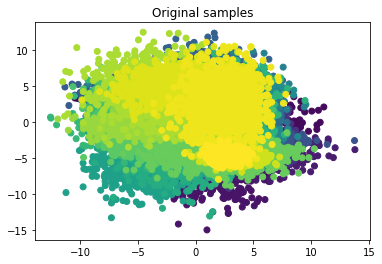

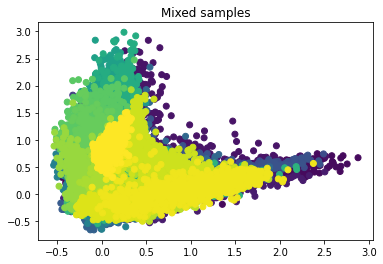

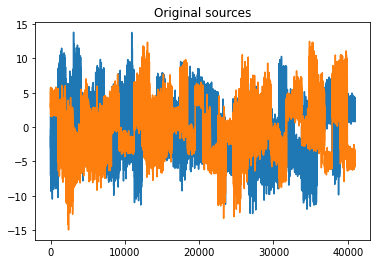

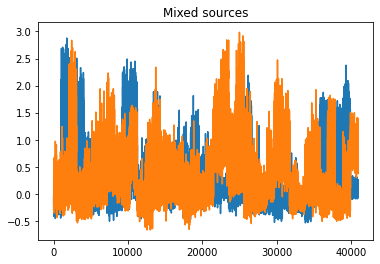

In [30]:
data_size = 5
latent_size = 5
U_size = 40
k = 2
L = 1024
batch_size = 64

#Define dataset
data_sampler = iVAE_datasets(data_size, U_size, L, k, batch_size = batch_size, randomise = True, random_seed = False, mod_flag = False, mix_L = 4, seed = True)

plt.figure()
plt.title("Original samples")
plt.scatter(data_sampler.data.cpu().numpy()[:, 0], data_sampler.data.cpu().numpy()[:, 1], c = data_sampler.sample_labels)
plt.show()

plt.figure()
plt.title("Mixed samples")
plt.scatter(data_sampler.mixed_data.cpu().numpy()[:, 0], data_sampler.mixed_data.cpu().numpy()[:, 1], c = data_sampler.sample_labels)
plt.show()

plt.figure()
plt.title("Original sources")
plt.plot(data_sampler.data.cpu().numpy()[:, 0])
plt.plot(data_sampler.data.cpu().numpy()[:, 1])
plt.show()

plt.figure()
plt.title("Mixed sources")
plt.plot(data_sampler.mixed_data.cpu().numpy()[:, 0])
plt.plot(data_sampler.mixed_data.cpu().numpy()[:, 1])
plt.show()


In [31]:
data_sampler.random_seed

False

# Version 1 - Using a OOP-based training approach (does not allow you to utilise the MCC per epoch).


cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]



Visualising the models
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

Encoder(
  (activation): LeakyReLU(negative_slope=0.1)
  (var_activation): Softplus(beta=1, threshold=20)
  (encode_net): Sequential(
    (0): Linear(in_features=45, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=128, out_features=128, bias=True)
  )
  (mu_layer): Linear(in_features=128, out_features=5, bias=True)
  (var_layer): Sequential(
    (0): Linear(in_features=128, out_features=5, bias=True)
    (1): Softplus(beta=1, threshold=20)
  )
)
Decoder(
  (activation): LeakyReLU(negative_slope=0.1)
  (decode_net): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=128, out_features=128, bias=True)
  )
  (


train cost: [6.23734, 0.05404, 0.8329], valid cost: [5.26696, 0.04658, 0.60933]:   0%|          | 0/100 [00:02<?, ?it/s]
train cost: [6.23734, 0.05404, 0.8329], valid cost: [5.26696, 0.04658, 0.60933]:   1%|          | 1/100 [00:02<04:54,  2.97s/it]
train cost: [3.09293, 0.02255, 0.83836], valid cost: [3.3581, 0.02502, 0.85627]:   1%|          | 1/100 [00:05<04:54,  2.97s/it]
train cost: [3.09293, 0.02255, 0.83836], valid cost: [3.3581, 0.02502, 0.85627]:   2%|▏         | 2/100 [00:06<04:53,  2.99s/it]
train cost: [2.07336, 0.01198, 0.87495], valid cost: [3.14783, 0.02349, 0.79894]:   2%|▏         | 2/100 [00:08<04:53,  2.99s/it]
train cost: [2.07336, 0.01198, 0.87495], valid cost: [3.14783, 0.02349, 0.79894]:   3%|▎         | 3/100 [00:08<04:47,  2.97s/it]
train cost: [1.89664, 0.0109, 0.80636], valid cost: [2.92358, 0.02173, 0.75014]:   3%|▎         | 3/100 [00:11<04:47,  2.97s/it] 
train cost: [1.89664, 0.0109, 0.80636], valid cost: [2.92358, 0.02173, 0.75014]:   4%|▍         | 4/1

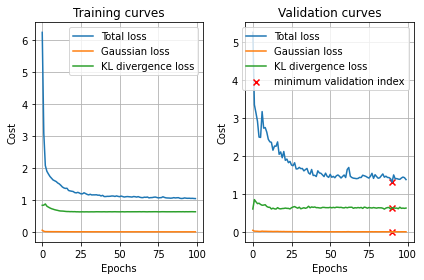

In [32]:
epochs = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
encode_dict = { "ff_layers":[data_size + U_size, 128, 128, 128, latent_size],
                "conv_flag":False }

decode_dict = { "ff_layers":[latent_size, 128, 128, 128, data_size],
                "conv_flag":False }

prior_dict = {  "ff_layers":[U_size, 128, 128, 128, latent_size],
                "conv_flag":False }

model = VAE_model(data_size, latent_size, U_size, encode_dict, decode_dict, prior_dict, var_decode = False, continuous_prior = False)
VAE_cost = VAE_loss("L2", gamma = 100, beta = 1, std_normal = False)

VAE_opt = VAE_optimiser(model, None)
my_trainer = VAE_trainer(model, VAE_opt, VAE_cost, data_sampler, data_sampler, epochs)

my_trainer.train_model()
my_trainer.plotter()

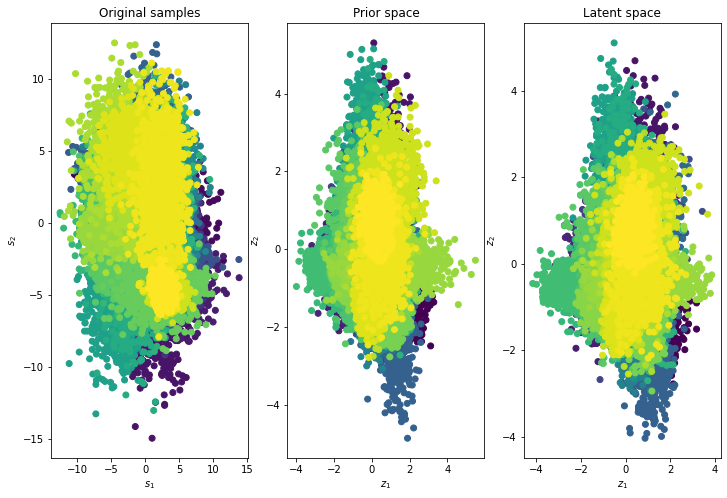

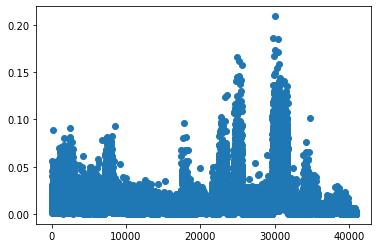

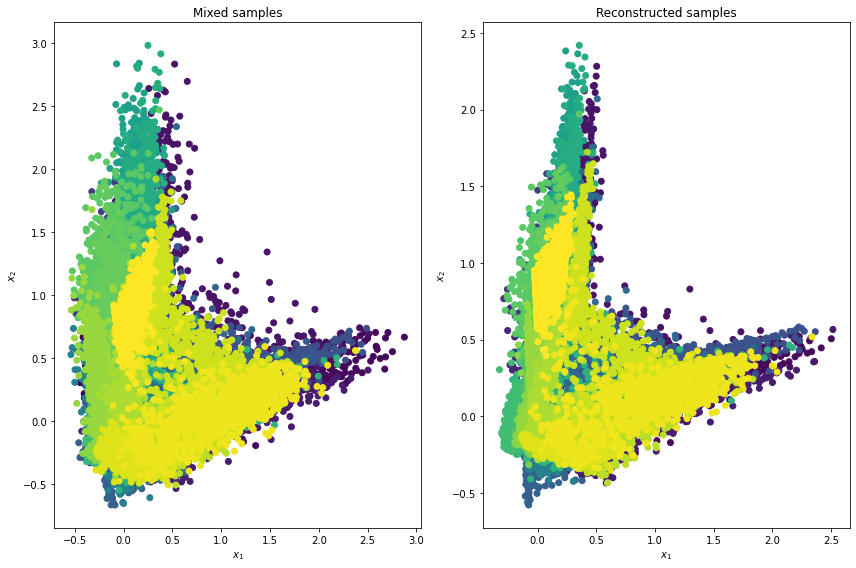

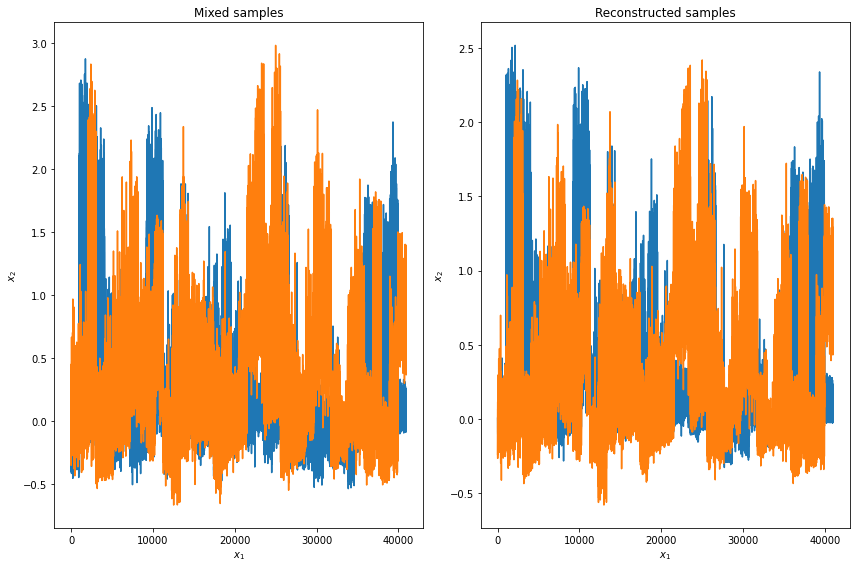

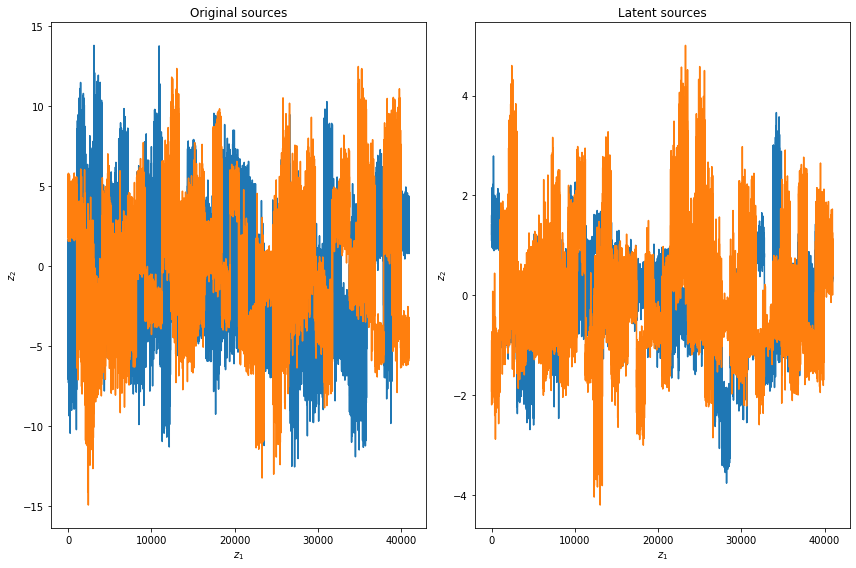

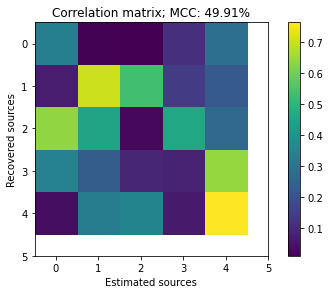

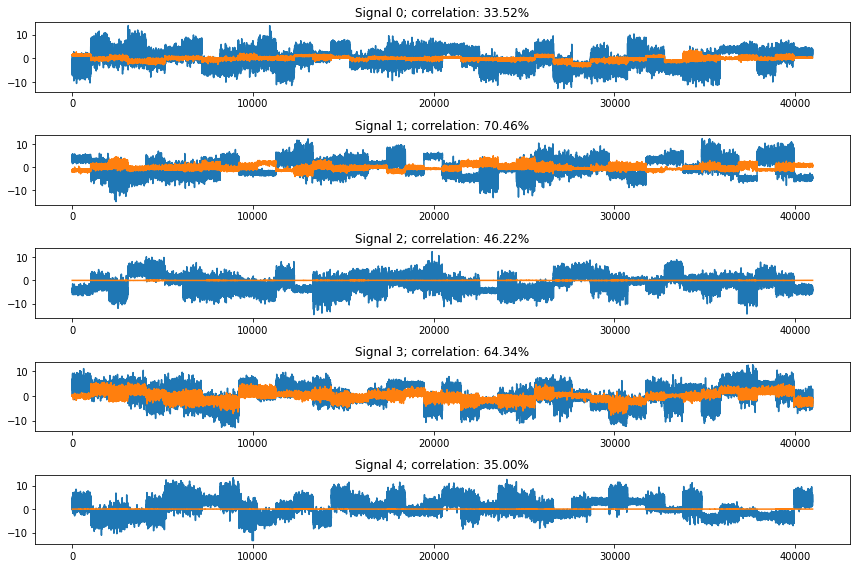

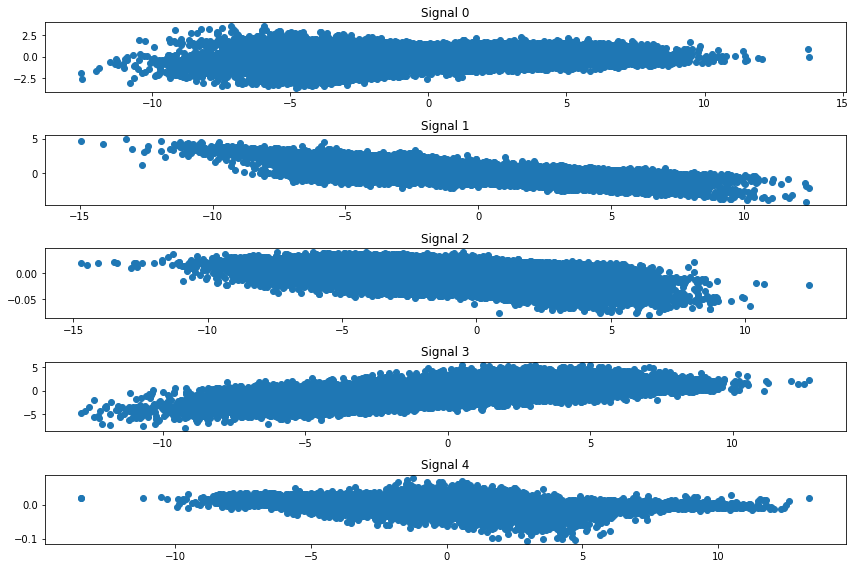

In [33]:
with torch.no_grad():

    #Prior outputs
    labels = torch.arange(0, U_size)
    mu, var = model.prior(labels.to(device))

    mu = mu.cpu().numpy()
    var = var.cpu().numpy()

    if model.U_size == 0: #Check to see if you perhaps trained a normal VAE!
        mu = np.repeat(mu, data_sampler.no_classes, axis = 0)
        var = np.repeat(var, data_sampler.no_classes, axis = 0)
    
    mu_new = mu[data_sampler.sample_labels.numpy(), :]
    var_new = var[data_sampler.sample_labels.numpy(), :]

    Z_new = mu_new + np.random.randn(len(data_sampler.sample_labels), latent_size) * np.sqrt(var_new)

    #Latent space and prior spaces
    fig, ax = plt.subplots(1, 3, figsize = (12, 8))
    ax = ax.flatten()

    #Original sources
    ax[0].set_title("Original samples")
    ax[0].scatter(data_sampler.data.cpu().numpy()[:, 0], data_sampler.data.cpu().numpy()[:, 1], c = data_sampler.sample_labels)
    ax[0].set_xlabel(r"$s_1$")
    ax[0].set_ylabel(r"$s_2$")


    #Prior space p(z|u)
    ax[1].set_title("Prior space")
    ax[1].scatter(Z_new[:, 0], Z_new[:, 1], c = data_sampler.sample_labels)
    ax[1].set_xlabel(r"$z_1$")
    ax[1].set_ylabel(r"$z_2$")

    #Encoder outputs
    z, var = model.encoder(data_sampler.mixed_data.to(device), data_sampler.sample_labels.to(device))

    z_scatter = z + torch.randn_like(z) * torch.sqrt(var)
    x_recon, var_recon = model.decoder(z, torch.zeros_like(var))

    error = torch.sum((x_recon - data_sampler.mixed_data.to(device))**2 / var_recon, dim = 1).numpy() / data_size

    x_recon = x_recon.cpu().numpy()
    z = z.cpu().numpy()

    #Latent space p(z|x, u)
    ax[2].set_title("Latent space")
    ax[2].scatter(z_scatter[:, 0], z_scatter[:, 1], c = data_sampler.sample_labels)
    ax[2].set_xlabel(r"$z_1$")
    ax[2].set_ylabel(r"$z_2$")
    plt.show()

    plt.figure()
    plt.scatter(np.arange(len(error)), error)
    plt.show()

    #Reconstruction - scatterplot
    fig, ax = plt.subplots(1, 2, figsize = (12, 8))
    ax = ax.flatten()
    ax[0].set_title("Mixed samples")
    ax[0].scatter(data_sampler.mixed_data.cpu().numpy()[:, 0], data_sampler.mixed_data.cpu().numpy()[:, 1], c = data_sampler.sample_labels)
    ax[0].set_xlabel(r"$x_1$")
    ax[0].set_ylabel(r"$x_2$")
    
    ax[1].set_title("Reconstructed samples")
    ax[1].scatter(x_recon[:, 0], x_recon[:, 1], c = data_sampler.sample_labels)
    ax[1].set_xlabel(r"$x_1$")
    ax[1].set_ylabel(r"$x_2$")
    plt.tight_layout()
    plt.show()

    #Reconstruction
    fig, ax = plt.subplots(1, 2, figsize = (12, 8))
    ax = ax.flatten()
    ax[0].set_title("Mixed samples")
    ax[0].plot(data_sampler.mixed_data.cpu().numpy()[:, 0])
    ax[0].plot(data_sampler.mixed_data.cpu().numpy()[:, 1])
    ax[0].set_xlabel(r"$x_1$")
    ax[0].set_ylabel(r"$x_2$")
    
    ax[1].set_title("Reconstructed samples")
    ax[1].plot(x_recon[:, 0])
    ax[1].plot(x_recon[:, 1])
    ax[1].set_xlabel(r"$x_1$")
    ax[1].set_ylabel(r"$x_2$")
    plt.tight_layout()
    plt.show()

    #Sources
    fig, ax = plt.subplots(1, 2, figsize = (12, 8))
    ax = ax.flatten()
    ax[0].set_title("Original sources")
    ax[0].plot(data_sampler.data.cpu().numpy()[:, 0])
    ax[0].plot(data_sampler.data.cpu().numpy()[:, 1])
    ax[0].set_xlabel(r"$z_1$")
    ax[0].set_ylabel(r"$z_2$")
    
    ax[1].set_title("Latent sources")
    ax[1].plot(z[:, 0])
    ax[1].plot(z[:, 1])
    ax[1].set_xlabel(r"$z_1$")
    ax[1].set_ylabel(r"$z_2$")
    plt.tight_layout()
    plt.show()

    """
    fig, ax = plt.subplots(5, 4, figsize = (10, 8))
    ax  = ax.flatten()
    fig.suptitle("Latent samples")
    for cnt, i in enumerate(range(0, 512 * U_size, 512)):
        ax[4 * cnt].scatter(data_sampler.data.cpu().numpy()[i:i + 512, 0], z[i:i + 512, 0])
        ax[4 * cnt + 1].scatter(data_sampler.data.cpu().numpy()[i:i + 512, 0], z[i:i + 512, 1])
        ax[4 * cnt + 2].scatter(data_sampler.data.cpu().numpy()[i:i + 512, 1], z[i:i + 512, 0])
        ax[4 * cnt + 3].scatter(data_sampler.data.cpu().numpy()[i:i + 512, 1], z[i:i + 512, 1])
    plt.tight_layout()
    plt.show()
    """


#########################################################
#CORRELATION
#########################################################
MCC, corr_vals = MCC_estimation(data_sampler.data.cpu().numpy(), z, PLOT = True)


# Version 2 - Using a loop-based training approach (no OOP but it does allow you to utilise the MCC per epoch).

In [ ]:
#Setup model for optimisation

encode_dict = { "ff_layers":[data_size + U_size, 128, 128, 128, latent_size],
                "conv_flag":False }

decode_dict = { "ff_layers":[latent_size, 128, 128, 128, data_size],
                "conv_flag":False }

prior_dict = {  "ff_layers":[U_size, 128, 128, 128, latent_size],
                "conv_flag":False }

encoder_model = Encoder(latent_size, U_size, data_size, encode_dict)
decoder_model = Decoder(latent_size, U_size, data_size, decode_dict, var_flag = False)
prior_model = ConditionalPrior(latent_size, U_size, data_size, prior_dict, continuous_prior = False)

print(encoder_model)
print(decoder_model)
print(prior_model)

print(dir(prior_model))

####################
#PARAMETERS
####################
epochs = 100

Lr_init = 1e-3
Lr_end = 1e-3

Loss_type = "L2"
noise_var_decoder = 1/100
Beta_VAE = 1

gamma_scheduler = 10**(np.log10(Lr_end / Lr_init) / epochs)
##################################

#Push models to device
encoder_model.to(encoder_model.device)
decoder_model.to(decoder_model.device)
prior_model.to(prior_model.device)

data_iterator = iter(data_sampler)

loss = VAE_loss(loss_name = Loss_type, gamma = 1/noise_var_decoder, beta = Beta_VAE, std_normal = False)

ls = list(encoder_model.parameters()) + list(decoder_model.parameters()) + list(prior_model.parameters())
optim = torch.optim.Adam(ls, lr= Lr_init)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer = optim, gamma = gamma_scheduler, verbose = False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

######################
#TRAIN
######################
total_cost_list = []
recon_cost_list = []
kl_cost_list = []
MCC = []

pbar = tqdm(total = epochs, desc = "cost at epoch {}: {}".format(0, np.inf)) 

for i in range(epochs):
    total_cost = 0
    recon_cost = 0
    kl_cost = 0
    N = 0
    for data in data_iterator:
      Xdata, labels = data
      
      mu_z_encoder, var_z_encoder = encoder_model(Xdata.to(device), labels.to(device))
      
      mu_z_prior, var_z_prior = prior_model(labels.to(device)) #labels).to(device)) #

      Xrecon = decoder_model(mu_z_encoder, var_z_encoder)

      loss_val, recon_loss, kl_loss = loss(Xdata, Xrecon, mu_z_encoder, var_z_encoder, mu_z_prior, var_z_prior)

      loss_val.backward()
      optim.step()
      optim.zero_grad()

      total_cost += loss_val.item()
      recon_cost += recon_loss.item()
      kl_cost += kl_loss.item()
      N += 1

    #Update scheduler
    scheduler.step()

    total_cost_list.append(total_cost / N)
    recon_cost_list.append(recon_cost / N)
    kl_cost_list.append(kl_cost / N)
    ###############
    #MCC for inputs, sub-optimal implementation, should rather loop through the elements in batches
    ###############
    with torch.no_grad():

      z, var = encoder_model(data_sampler.mixed_data.to(device), data_sampler.sample_labels.to(device))

      MCC_iter, _ = MCC_estimation(data_sampler.data.cpu().numpy(), z, PLOT = False)
      MCC.append(MCC_iter)

    pbar.set_description("cost[MSE, KL]/MCC at epoch {}: [{:.4f}, {:.4f}]/{:.2f}%".format(i, recon_cost_list[-1], kl_cost_list[-1], MCC_iter*100))
    pbar.update(1)

pbar.close()

plt.figure()
plt.plot(total_cost_list, label = "total loss")
plt.plot(recon_cost_list, label = "reconstruction loss")
plt.plot(kl_cost_list, label = "KL divergence loss")
plt.ylabel("Loss cost")
plt.xlabel("Epochs")
plt.legend()
plt.show()

plt.figure()
plt.plot(MCC, label = "Mean cross correlation")
plt.ylabel("MCC")
plt.xlabel("Epochs")
plt.legend()
plt.show()


cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Encoder(
  (activation): LeakyReLU(negative_slope=0.1)
  (var_activation): Softplus(beta=1, threshold=20)
  (encode_net): Sequential(
    (0): Linear(in_features=45, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=128, out_features=128, bias=True)
  )
  (mu_layer): Linear(in_features=128, out_features=5, bias=True)
  (var_layer): Sequential(
    (0): Linear(in_features=128, out_features=5, bias=True)
    (1): Softplus(beta=1, threshold=20)
  )
)
Decoder(
  (activation): LeakyReLU(negative_slope=0.1)
  (decode_net): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=128, out_features=128, bias=True)
  )
  (gen_layer): Linear(in_features=128, out_features=


cost[MSE, KL]/MCC at epoch 0: [0.0451, 1.0351]/47.66%:   0%|          | 0/100 [00:02<?, ?it/s]
cost[MSE, KL]/MCC at epoch 0: [0.0451, 1.0351]/47.66%:   1%|          | 1/100 [00:02<03:59,  2.42s/it]
cost[MSE, KL]/MCC at epoch 1: [0.0162, 0.8961]/45.92%:   1%|          | 1/100 [00:04<03:59,  2.42s/it]
cost[MSE, KL]/MCC at epoch 1: [0.0162, 0.8961]/45.92%:   2%|▏         | 2/100 [00:04<03:57,  2.43s/it]
cost[MSE, KL]/MCC at epoch 2: [0.0106, 0.8399]/44.20%:   2%|▏         | 2/100 [00:07<03:57,  2.43s/it]
cost[MSE, KL]/MCC at epoch 2: [0.0106, 0.8399]/44.20%:   3%|▎         | 3/100 [00:07<03:54,  2.41s/it]
cost[MSE, KL]/MCC at epoch 3: [0.0101, 0.8041]/43.70%:   3%|▎         | 3/100 [00:09<03:54,  2.41s/it]
cost[MSE, KL]/MCC at epoch 3: [0.0101, 0.8041]/43.70%:   4%|▍         | 4/100 [00:09<03:52,  2.42s/it]
cost[MSE, KL]/MCC at epoch 4: [0.0098, 0.7717]/45.33%:   4%|▍         | 4/100 [00:12<03:52,  2.42s/it]
cost[MSE, KL]/MCC at epoch 4: [0.0098, 0.7717]/45.33%:   5%|▌         | 5/100 [0

In [ ]:
with torch.no_grad():

    labels = torch.arange(0, U_size)
    U = torch.eye(U_size)
    mu, var = model.prior_model(labels.to(device))#

    mu = mu.cpu().numpy()
    var = var.cpu().numpy()

    mu_new = mu[data_sampler.sample_labels.numpy(), :]
    var_new = var[data_sampler.sample_labels.numpy(), :]

    Z_new = mu_new + np.random.randn(len(data_sampler.sample_labels), latent_size) * np.sqrt(var_new)

    #Latent space and prior spaces
    fig, ax = plt.subplots(1, 3, figsize = (12, 8))
    ax = ax.flatten()

    #Original sources
    ax[0].set_title("Original samples")
    ax[0].scatter(data_sampler.data.cpu().numpy()[:, 0], data_sampler.data.cpu().numpy()[:, 1], c = data_sampler.sample_labels)
    ax[0].set_xlabel(r"$s_1$")
    ax[0].set_ylabel(r"$s_2$")


    #Prior space p(z|u)
    ax[1].set_title("Prior space")
    ax[1].scatter(Z_new[:, 0], Z_new[:, 1], c = data_sampler.sample_labels)
    ax[1].set_xlabel(r"$z_1$")
    ax[1].set_ylabel(r"$z_2$")

    U = torch.zeros(len(data_sampler.mixed_data), data_sampler.no_classes)
    U[range(U.size(0)), data_sampler.sample_labels] = 1
    z, var = encoder_model(data_sampler.mixed_data.to(device), U.to(device))

    z_scatter = z + torch.randn_like(z) * torch.sqrt(var)
    recon, _ = decoder_model(z, torch.zeros_like(var))

    error = torch.sum((recon - data_sampler.mixed_data.to(device))**2, dim = 1).numpy() / data_size

    recon = recon.cpu().numpy()
    z = z.cpu().numpy()

    #Latent space p(z|x, u)
    ax[2].set_title("Latent space")
    ax[2].scatter(z_scatter[:, 0], z_scatter[:, 1], c = data_sampler.sample_labels)
    ax[2].set_xlabel(r"$z_1$")
    ax[2].set_ylabel(r"$z_2$")
    plt.show()

    plt.figure()
    plt.scatter(np.arange(len(error)), error)
    plt.show()

    #Reconstruction - scatterplot
    fig, ax = plt.subplots(1, 2, figsize = (12, 8))
    ax = ax.flatten()
    ax[0].set_title("Mixed samples")
    ax[0].scatter(data_sampler.mixed_data.cpu().numpy()[:, 0], data_sampler.mixed_data.cpu().numpy()[:, 1], c = data_sampler.sample_labels)
    ax[0].set_xlabel(r"$x_1$")
    ax[0].set_ylabel(r"$x_2$")
    
    ax[1].set_title("Reconstructed samples")
    ax[1].scatter(recon[:, 0], recon[:, 1], c = data_sampler.sample_labels)
    ax[1].set_xlabel(r"$x_1$")
    ax[1].set_ylabel(r"$x_2$")
    plt.tight_layout()
    plt.show()

    #Reconstruction
    fig, ax = plt.subplots(1, 2, figsize = (12, 8))
    ax = ax.flatten()
    ax[0].set_title("Mixed samples")
    ax[0].plot(data_sampler.mixed_data.cpu().numpy()[:, 0])
    ax[0].plot(data_sampler.mixed_data.cpu().numpy()[:, 1])
    ax[0].set_xlabel(r"$x_1$")
    ax[0].set_ylabel(r"$x_2$")
    
    ax[1].set_title("Reconstructed samples")
    ax[1].plot(recon[:, 0])
    ax[1].plot(recon[:, 1])
    ax[1].set_xlabel(r"$x_1$")
    ax[1].set_ylabel(r"$x_2$")
    plt.tight_layout()
    plt.show()

    #Sources
    fig, ax = plt.subplots(1, 2, figsize = (12, 8))
    ax = ax.flatten()
    ax[0].set_title("Original sources")
    ax[0].plot(data_sampler.data.cpu().numpy()[:, 0])
    ax[0].plot(data_sampler.data.cpu().numpy()[:, 1])
    ax[0].set_xlabel(r"$z_1$")
    ax[0].set_ylabel(r"$z_2$")
    
    ax[1].set_title("Latent sources")
    ax[1].plot(z[:, 0])
    ax[1].plot(z[:, 1])
    ax[1].set_xlabel(r"$z_1$")
    ax[1].set_ylabel(r"$z_2$")
    plt.tight_layout()
    plt.show()

    """
    fig, ax = plt.subplots(5, 4, figsize = (10, 8))
    ax  = ax.flatten()
    fig.suptitle("Latent samples")
    for cnt, i in enumerate(range(0, 512 * U_size, 512)):
        ax[4 * cnt].scatter(data_sampler.data.cpu().numpy()[i:i + 512, 0], z[i:i + 512, 0])
        ax[4 * cnt + 1].scatter(data_sampler.data.cpu().numpy()[i:i + 512, 0], z[i:i + 512, 1])
        ax[4 * cnt + 2].scatter(data_sampler.data.cpu().numpy()[i:i + 512, 1], z[i:i + 512, 0])
        ax[4 * cnt + 3].scatter(data_sampler.data.cpu().numpy()[i:i + 512, 1], z[i:i + 512, 1])
    plt.tight_layout()
    plt.show()
    """


#########################################################
#CORRELATION
#########################################################
MCC, corr_vals = MCC_estimation(data_sampler.data.cpu().numpy(), z, PLOT = True)
